In [1]:
import numpy as np
import pandas as pd
import sys
import seaborn
import math
import matplotlib
import matplotlib.ticker
from matplotlib import pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

seaborn.set()
seaborn.set_style("white")
seaborn.set_context("poster")
from matplotlib import pyplot

In [2]:
def get_slope(res):
    
    res[res == 0]  = np.nan

    res_tmp = np.zeros((np.shape(res)[0],np.shape(res)[1]-2))
    for i in range(1,np.shape(res)[1]-1):
        res_tmp[:, i-1] = (res[:,i+1,0] / res[:,i,0] ) 
    x = np.nanmean(res_tmp, axis=1)
    #x = res_tmp
    x  = x [~np.isnan(x )]
    x  = x [x >0]
    return x

def update_results(ablation_results, factor, curve_idx, size_idx, factor_multiplier):

    results[seed, :, :, curve_idx, size_idx] = comp * (1/factor) * factor_multiplier
    results_no[seed, :, :, curve_idx, size_idx] = 1/2**(4-size_idx) - comp * (1/factor) * factor_multiplier

def update_results_imagenet(ablation_results, factor, curve_idx, size_idx, factor_multiplier):

    results[seed, :, curve_idx, size_idx] = comp * (1/factor) * factor_multiplier
    results_no[seed, :, curve_idx, size_idx] = 1/2**(4-size_idx) - comp * (1/factor) * factor_multiplier

    
def get_mean_std(res):

    results_tmp=np.zeros((curves,sizes,2))
    results_tmp[:,:,0] = np.mean( res, axis=(0,1,2))
    results_tmp[:,:,1] = np.std( res, axis=(0,1,2)) 
    return results_tmp

 
def get_mean_std_imagenet(res):

    results_tmp=np.zeros((curves,sizes,2))
    results_tmp[:,:,0] = np.mean( res, axis=(0,1))
    results_tmp[:,:,1] = np.std( res, axis=(0,1)) 
    return results_tmp


def print_similarity(title, data, marker_styles, curve_colors, curve_styles, 
                     curve_labels, yticks, leg_title, rand_base, leg_loc, leg_flag, 
                     name, log_y, non, slopes, ncol=1, include_ylabel=True):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.xaxis.tick_bottom() ### CHANGED
    ax.yaxis.tick_left() ### CHANGED
    plt.title(title , fontsize=25)
    plt.xlabel(r'Model Size Factor', fontsize=25)
    plt.xlim((0.245, 4.07))
    if log_y:
        plt.ylim(0.25, np.max(yticks))
        plt.yscale('log', basey=2)
    else:
        plt.ylim(-.0, np.max(yticks))
        from matplotlib.ticker import FormatStrFormatter
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
    if include_ylabel:
        if non:
            plt.ylabel('Non-Redundancy', fontsize=25)
        else:
            plt.ylabel('Redundancy', fontsize=25)

    #plt.grid(True, which='both')
    plt.xscale('log', basex=2)        
    plt.xticks(size_factors, size_labels)
    plt.yticks(yticks)

    for curve_idx in range(np.shape(data)[0]):
        non_0_idx = (data[curve_idx,:,0] != -1)
        plt.errorbar(size_factors[non_0_idx], data[curve_idx,non_0_idx,0], yerr=data[curve_idx,non_0_idx,1].T,
                 marker=marker_styles[curve_idx], markersize=7, color=curve_colors[curve_idx],
                 linestyle=curve_styles[curve_idx], linewidth=3)

    if leg_flag:
        leg = plt.legend(curve_labels, loc=leg_loc, framealpha=0.8, fontsize=10, title=leg_title, ncol=ncol)
        leg.get_title().set_fontsize('10')
    
    import math
    if not np.any(np.isnan(data[:,3,0])):
        plt.annotate(r"$g_{max}=$" + "{:.2f}".format(np.max(slopes)), xy= (math.log(3,2), np.max(data[:,3,0])),\
                 horizontalalignment='right', fontsize=14)
    else:
        if not slopes.size==0:
            plt.annotate(r"$g_{max}=$" + "{:.2f}".format(np.max(slopes)), xy= (math.log(2,2), np.max(data[:,2,0])),\
                 horizontalalignment='right', verticalalignment='bottom', fontsize=14)
            
    if not slopes.size==0:
        plt.annotate(r"$g_{min}=$" + "{:.2f}".format(np.min(slopes)), xy= (math.log(2,2), np.min(data[:,1,0])),\
                 horizontalalignment='left', fontsize=14)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(15)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    
    plt.rc('xtick',labelsize=8)
    plt.show()
    savename = name+".pdf" #if not log_y else name + '_log_y.pdf'
    fig.savefig(savename, format='pdf', bbox_inches='tight',dpi=1000)
    



def set_results(ID, experiments, size_idx, units, layer=None):

    csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
    csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
    df = pd.read_csv(csv_file)


    if layer == None:
        comp = np.zeros((crosses, len(units)))  ### SC

        for lyr in range(len(units)):  ### SC

            comp[:,lyr] =  np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == str(lyr)]
                                        ['compressability_95'].iloc[0] for i in range(crosses)]) # * opt.dnn.neuron_multiplier[0]/4 #* 1 / (4*alexnet_units[lyr])
    else:
        comp = np.zeros((crosses, 1))  ### SC

        comp[:,0] =  np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == str(layer)]
                                ['compressability_95'].iloc[0] for i in range(crosses)]) # * opt.dnn.neuron_multiplier[0]/4 #* 1 / (4*alexnet_units[lyr])
    
    return comp


def set_results_imagenet(ID, experiments, size_idx, units, layer=None):

    csv_file = opt.csv_dir + opt.name + '_redundancy.csv'  
    df = pd.read_csv(csv_file)

    comp = np.zeros(( len(units)))  ### SC

    if layer == None:
        for lyr in range(len(units)):  ### SC

            comp[lyr] =  np.array(df[df['evaluation_set'] == 'validation'][df['layer'] == str(lyr)]
                                    ['compressability_95'].iloc[0])
    else:
        
        comp[0] =  np.array(df[df['evaluation_set'] == 'validation'][df['layer'] == layer]
                                ['compressability_95'].iloc[0]) 
        
    return comp




In [3]:
sys.path.append('../')

import experiments

curves = 4
curve_labels = ['AlexNet', 'AlexNet-Random', 'ResNet56', 'ResNet56-Random']
curve_colors = ['darkblue', 'darkblue', 'indianred', 'indianred']
curve_styles = ['-', ':', '-', ':']
marker_styles = ['o', 'v', 'o', 'v']
sizes = 5
yticks = [0, 2, 4, 6]  ### SC
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
seeds = 2

alexnet_units = [96, 256, 384, 192]  ### SC
resnet_units = [16, 16, 32, 64]  ### SC

results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
# both are indexed [size_factor][nn_type][avg/std]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets
for seed in range(seeds):
    for ID in range(62, 92):

        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            curve_idx = 1  # random labels
        elif opt.hyper.augmentation and opt.hyper.drop_train < 1:
            curve_idx = 0  # all regularizers
        else:
            continue
            
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        comp = set_results(ID, experiments, size_idx, alexnet_units)
        update_results(comp, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])
      

    for ID in range(217, 231):

        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            curve_idx = 3  # random labels
        elif opt.hyper.lr_bs_factor == 1:
            curve_idx = 2  # all regularizers
        else:
            continue
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]
        comp = set_results(ID, experiments, size_idx, resnet_units)
        
        update_results(comp, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


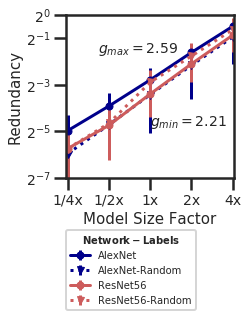

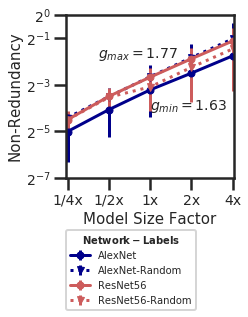

In [4]:

yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0, 1/4,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0, -0.81)

print_similarity('', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network-Labels}$", 10, leg_loc, True,
                "red_cifar_rand", True, False, slopes)

print_similarity('', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network-Labels}$", 10, leg_loc, True,
                "nonred_cifar_rand", True, True, slopes_no)

In [5]:
# Regularizers CIFAR

sys.path.append('../')

import experiments

curves = 5
curve_labels = ['None', 'All', 'DataAug.', 'Dropout', 'W. Decay']
curve_colors = ['slateblue', 'darkblue', 'purple', 'violet', 'pink']
curve_styles = ['-', '-', '--', '--', '--']
marker_styles = ['o', 'o', 'v', 'v', 'v']
sizes = 5
yticks = [0, 2, 4, 6]  ### SC
yticks_log = [1/64, 1/8, 1, 8]  ### SC
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
seeds =2


alexnet_units = [96, 256, 384, 192]  ### SC

results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
# both are indexed [size_factor][nn_type][avg/std]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets


for seed in range(seeds):
    for ID in range(62, 92):

        opt = experiments.opt[ID]

        curve_idx = 0  # unregularized
        if opt.dataset.random_labels:
            continue
        elif opt.hyper.augmentation and opt.hyper.drop_train < 1:
            curve_idx = 1  # all regularizers
        elif opt.hyper.augmentation:
            curve_idx = 2
        elif opt.hyper.drop_train < 1:
            curve_idx = 3
        elif opt.hyper.weight_decay:
            curve_idx = 4
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        comp = set_results(ID, experiments, size_idx, resnet_units)
        
        update_results(comp, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

leg_loc = (0.01, 0.37)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


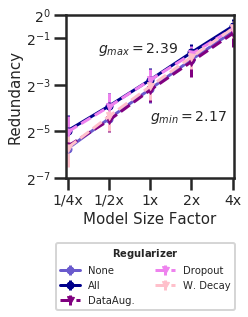

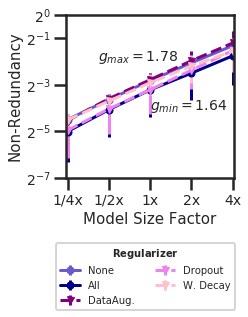

In [6]:

yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0, 1/4,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (-.06, -0.81)

print_similarity('', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Regularizer}$", 10, leg_loc, True,
                "red_cifar_regularizers", True, False, slopes, ncol=2)
print_similarity('', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Regularizer}$", 10, leg_loc, True,
                "nonred_cifar_regularizers", True, True, slopes_no, ncol=2)


In [7]:
#Batch/LR (ResNet + AlexNet base) CIFAR

sys.path.append('../')

import experiments

curves = 6
curve_labels = ['AlexNet-k=1', 'AlexNet-k=0.25', 'AlexNet-k=4', 'ResNet-k=1', 'ResNet-k=0.25', 'ResNet-k=4']
curve_colors = ['slateblue', 'lightblue', 'lightblue', 'indianred', 'mistyrose', 'mistyrose']
curve_styles = ['-', '--', '--', '-', '--', '--']
marker_styles = ['o', 'v', 's', 'o', 'v', 's']
sizes = 5
yticks = [0, 2, 4, 6]  ### SC
yticks_log = [1/64, 1/8, 1, 8]  ### SC
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 1
seeds = 1



results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))

lr_factor = [1, 0.25, 4]

alexnet_units = [96, 256, 384, 192]  ### SC
resnet_units = [16, 16, 32, 64]  ### SC

# both are indexed [size_factor][nn_type][avg/std]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

for seed in range(seeds):
    for ID in list(range(62, 92)) + list(range(157,217)) :

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            continue
        if not (opt.hyper.augmentation or opt.hyper.drop_train < 1 or opt.hyper.weight_decay):
            curve_idx = np.where(np.array(opt.hyper.lr_bs_factor) == lr_factor)[0][0]
        else:
            continue
            
        if ID == 166: #Not possible to calculate
            continue
            
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        comp = set_results(ID, experiments, size_idx, alexnet_units)
        
        update_results(comp, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])
        
        
        
    for ID in list(range(217,232)) + list(range(234,239)):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            continue
        else:
            curve_idx = np.where(np.array(opt.hyper.lr_bs_factor) == lr_factor)[0][0] + 3
            
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        comp = set_results(ID, experiments, size_idx, resnet_units)
        
        update_results(comp, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

leg_loc = (0.01, 0.37)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


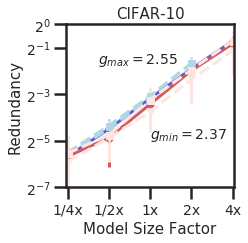

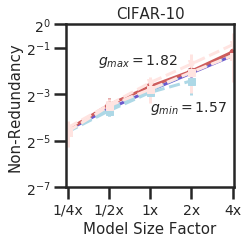

In [8]:


yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0, 1/4,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0, -1)

print_similarity('CIFAR-10', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network-k}$", 10, leg_loc, False,
                "red_cifar_batch", True, False, slopes)

print_similarity('CIFAR-10', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network-k}$", 10, leg_loc, False,
                "nonred_cifar_batch", True, True, slopes_no)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


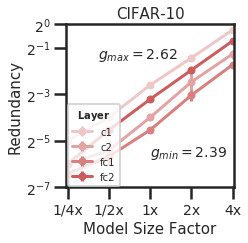

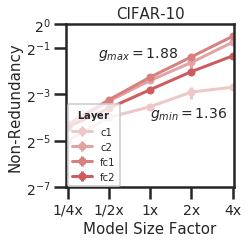

In [9]:
#Layer - CIFAR

sys.path.append('../')

import experiments

curves = 4
curve_labels = ['c1',  'c2', 'fc1', 'fc2']
cm = seaborn.light_palette("indianred", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=curves+1)][1:]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o', 'o']

sizes = 5
yticks = [0, 2, 5, 10, 20]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
seeds = 2

# both are indexed [size_factor][nn_type][avg/std]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets
resnet_units = [16, 16, 32, 64]  ### SC
results = np.zeros((seeds,crosses, len(resnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(resnet_units), curves, sizes))

for seed in range(seeds):        
    for ID in list(range(217,232)) + list(range(234,239)):
        for idx_layer, layer in enumerate([0, 1, 2, 3]):

            #print('Processing ID:', ID)
            opt = experiments.opt[ID]

            if opt.dataset.random_labels or not opt.hyper.lr_bs_factor == 1:
                continue

            size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

            comp = set_results(ID, experiments, size_idx, resnet_units, layer)

            update_results(comp, 4, idx_layer, \
                           size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

leg_loc = (0.01, 0.01)
print_similarity('CIFAR-10', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 10, leg_loc, True,
                "red_cifar_layer", True, False, slopes)

print_similarity('CIFAR-10', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 10, leg_loc, True,
                "nonred_cifar_layer", True, True, slopes_no)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


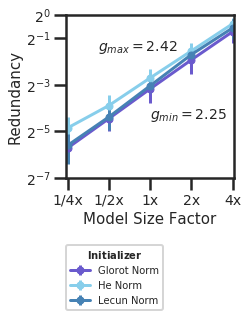

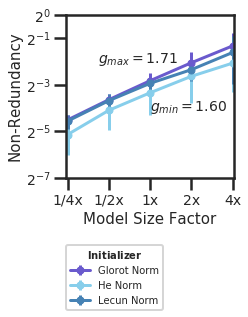

In [10]:
# Initializers CIFAR

sys.path.append('../')

import experiments

curves = 3
curve_labels = ['Glorot Norm', 'He Norm', 'Lecun Norm']
curve_colors = ['slateblue', 'skyblue', 'steelblue']
curve_styles = ['-',  '-',  '-']
marker_styles = ['o', 'o','o']
sizes = 5
yticks = [0, 2, 4, 6, 8]  ### SC
yticks_log = [1/64, 1/8, 1, 8]  ### SC
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
seeds =3

alexnet_units = [96, 256, 384, 192]  ### SC


results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
# both are indexed [size_factor][nn_type][avg/std]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

for seed in range(seeds):
    for ID in range(2,32):

        opt = experiments.opt[ID]

        curve_idx = opt.init_type // 2
        if opt.init_type in [1, 3, 5]:
            continue
            
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        comp = set_results(ID, experiments, size_idx, alexnet_units)
        
        update_results(comp, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


leg_loc = (0.02, 0.5)
leg_loc2 = (0.45, 0.01)

yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0, 1/4,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0, -0.81)

print_similarity('', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 10, leg_loc, True,
                "red_cifar_initializers", True, False, slopes)

print_similarity('', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 10, leg_loc, True,
                "nonred_cifar_initializers", True, True, slopes_no)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


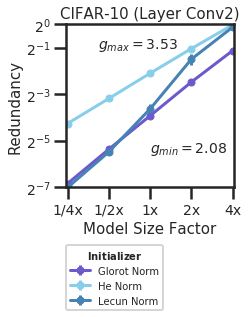

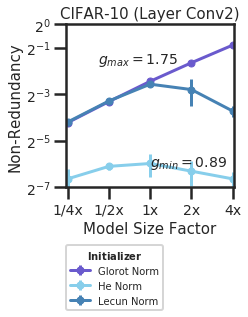

In [11]:
curves = 3
curve_labels = ['Glorot Norm', 'He Norm', 'Lecun Norm']
curve_colors = ['slateblue', 'skyblue', 'steelblue']
curve_styles = ['-',  '-',  '-']
marker_styles = ['o', 'o','o']
sizes = 5
yticks = [0, 2, 4, 6, 8]  ### SC
yticks_log = [1/64, 1/8, 1, 8]  ### SC
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
seeds =3

alexnet_units = [96, 256, 384, 192]  ### SC


results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
# both are indexed [size_factor][nn_type][avg/std]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

for seed in range(seeds):
    for ID in range(2,32):

        opt = experiments.opt[ID]

        curve_idx = opt.init_type // 2
        if opt.init_type in [1, 3, 5]:
            continue
            
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        comp = set_results(ID, experiments, size_idx, alexnet_units, layer=1)
        
        update_results(comp, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


leg_loc = (0.02, 0.5)
leg_loc2 = (0.45, 0.01)

yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0, 1/4,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0, -0.75)

print_similarity('CIFAR-10 (Layer Conv2)', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 10, leg_loc, True,
                "red_cifar_initializers_conv2", True, False, slopes)

print_similarity('CIFAR-10 (Layer Conv2)', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 10, leg_loc, True,
                "nonred_cifar_initializers_conv2", True, True, slopes_no)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


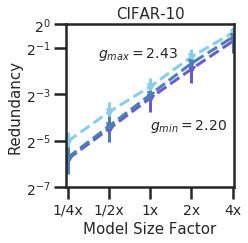

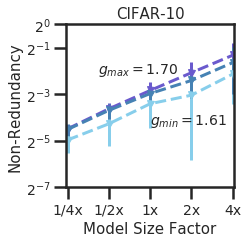

In [12]:
# Initializers CIFAR

sys.path.append('../')

import experiments

curves = 3
curve_labels = ['Glorot Unif.', 'He Unif.', 'Lecun Unif.']
curve_colors = ['slateblue', 'skyblue',  'steelblue']
curve_styles = ['--', '--', '--']
marker_styles = ['v', 'v', 'v']
sizes = 5
yticks = [0, 2, 4, 6]  ### SC
yticks_log = [1/64, 1/8, 1, 8]  ### SC
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
seeds =2

alexnet_units = [96, 256, 384, 192]  ### SC


results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
# both are indexed [size_factor][nn_type][avg/std]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

for seed in range(seeds):
    for ID in range(2,32):

        opt = experiments.opt[ID]

        curve_idx = opt.init_type // 2
        if opt.init_type in [0, 2, 4]:
            continue        
            
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        comp = set_results(ID, experiments, size_idx, alexnet_units)
        
        update_results(comp, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0, 1/4,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0.01, 0.01)


print_similarity('CIFAR-10', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network-Labels}$", 10, leg_loc, False,
                "red_cifar_initializers_uni", True, False, slopes)

print_similarity('CIFAR-10', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network-Labels}$", 10, leg_loc, False,
                "nonred_cifar_initializers_uni", True, True, slopes_no)

In [13]:
import pickle

with open('ids_mlps.p', 'rb') as handle:
    IDs = pickle.load(handle)
    
dataset_idx_map = {"rand10": 0, "rand10000": 1}
data_idx_map = {1e3: 0, 1e4: 1, 1e5: 2}
optimizer_idx_map = {0: 0, 1: 1, 2: 2, 5: 3}
init_idx_map = {1e-2: 0, 1e-1:1, 1:2, 1e1:3, 1e2:4, 1e3:5, 1e4:6, 1e5:7, 1e6:8, 1e7:9}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


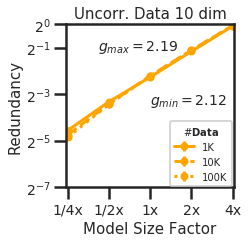

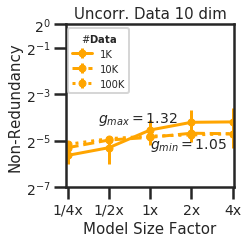

In [14]:
#Base - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curves = 3
curve_labels = ['1K', '10K', '100K']
curve_colors = ['orange', 'orange', 'orange']
curve_styles = ['-', '--',':' ]
marker_styles = ['o', 'o', 'o']

size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
factors = [1, 2, 4, 8, 16]
#select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 3

#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))

units = [128]
# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        
        if curve_idx == 0:
            dataset_idx = dataset_idx_map["rand10"]
            data_idx = data_idx_map[1e3]
        elif  curve_idx == 1:
            dataset_idx = dataset_idx_map["rand10"]
            data_idx = data_idx_map[1e4]
        elif  curve_idx == 2:
            dataset_idx = dataset_idx_map["rand10"]
            data_idx = data_idx_map[1e5]
         
        for size_idx in range(sizes):
            id_best = int(IDs[1][seed, dataset_idx, data_idx, optimizer_idx, size_idx])
            opt = experiments.opt[id_best]

            comp = set_results(id_best, experiments, size_idx, units)
            update_results(comp, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0, 1/16, 1/8]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (.62, .01)
print_similarity('Uncorr. Data 10 dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"#$\bf{Data}$", 10, leg_loc, True,
                "red_synth_10_data", True, False, slopes)
leg_loc = (.01, .58)
print_similarity('Uncorr. Data 10 dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"#$\bf{Data}$", 10, leg_loc, True,
                "nonred_synth_10_data", True, True, slopes_no)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


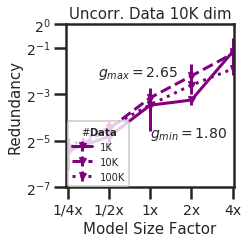

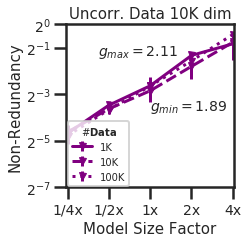

In [15]:
#Base - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curves = 3
curve_labels = ['1K', '10K', '100K']
curve_colors = ['purple','purple','purple']
curve_styles = [ '-', '--', ':']
marker_styles = [ 'v',  'v','v']

size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
factors = [1, 2, 4, 8, 16]
#select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 3

#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))

units = [128]
# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        
        if curve_idx == 0:
            dataset_idx = dataset_idx_map["rand10000"]
            data_idx = data_idx_map[1e3]
        elif  curve_idx == 1:
            dataset_idx = dataset_idx_map["rand10000"]
            data_idx = data_idx_map[1e4]
        elif  curve_idx == 2:
            dataset_idx = dataset_idx_map["rand10000"]
            data_idx = data_idx_map[1e5]
         
        for size_idx in range(sizes):
            id_best = int(IDs[1][seed, dataset_idx, data_idx, optimizer_idx, size_idx])
            opt = experiments.opt[id_best]

            comp = set_results(id_best, experiments, size_idx, units)
            update_results(comp, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0,  1/4, 1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (.01, 0.01)

print_similarity('Uncorr. Data 10K dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"#$\bf{Data}$", 10, leg_loc, True,
                "red_synth_10k_data", True, False, slopes)

print_similarity('Uncorr. Data 10K dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log , r"#$\bf{Data}$", 10, leg_loc, True,
                "nonred_synth_10k_data", True, True, slopes_no)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


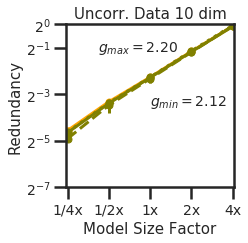

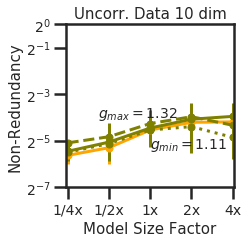

In [16]:
#Base - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curves = 4
curve_labels = ['Momentum', 'SGD', 'Adam', 'RMSprop']
curve_colors = ['orange','olive', 'olive', 'olive']
curve_styles = ['-','-', '--',':']
marker_styles = ['o', 'o', 'o', 'o']

size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
factors = [1, 2, 4, 8, 16]
#select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 3


#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))

units = [128]
# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        data_idx = data_idx_map[1e3]
        if curve_idx == 0:
            dataset_idx = dataset_idx_map["rand10"]
            optimizer_idx = optimizer_idx_map[0]
        elif curve_idx == 1:
            dataset_idx = dataset_idx_map["rand10"]
            optimizer_idx = optimizer_idx_map[1]
        elif  curve_idx == 2:
            dataset_idx = dataset_idx_map["rand10"]
            optimizer_idx = optimizer_idx_map[2]
        elif  curve_idx == 3:
            dataset_idx = dataset_idx_map["rand10"]
            optimizer_idx = optimizer_idx_map[5]
         
        for size_idx in range(sizes):
            id_best = int(IDs[1][seed, dataset_idx, data_idx, optimizer_idx, size_idx])
            opt = experiments.opt[id_best]

            comp = set_results(id_best, experiments, size_idx, units)
            update_results(comp, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

yticks_log2 = [0,  1/8, 1/4]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0.01, 0.01)
print_similarity('Uncorr. Data 10 dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Optimizer}$", 10, leg_loc, False,
                "red_synth_10_optimizer", True, False, slopes)
leg_loc = (0.01, 0.48)
print_similarity('Uncorr. Data 10 dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log , r"$\bf{Optimizer}$", 10, leg_loc, False,
                "nonred_synth_10_optimizer", True, True, slopes_no)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


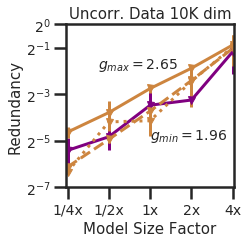

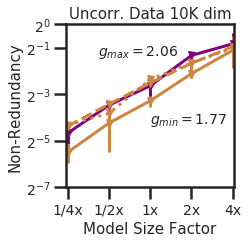

In [17]:
#Base - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curves = 4
curve_labels = ['Momentum', 'SGD', 'Adam', 'RMSprop']
curve_colors = ['purple', 'peru','peru','peru']
curve_styles = ['-', '-', '--', ':']
marker_styles = ['v','v',  'v','v']

size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
factors = [1, 2, 4, 8, 16]
#select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 3


#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))

units = [128]
# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        data_idx = data_idx_map[1e3]
        if curve_idx == 0:
            dataset_idx = dataset_idx_map["rand10000"]
            optimizer_idx = optimizer_idx_map[0]
        elif curve_idx == 1:
            dataset_idx = dataset_idx_map["rand10000"]
            optimizer_idx = optimizer_idx_map[1]
        elif  curve_idx == 2:
            dataset_idx = dataset_idx_map["rand10000"]
            optimizer_idx = optimizer_idx_map[2]
        elif  curve_idx == 3:
            dataset_idx = dataset_idx_map["rand10000"]
            optimizer_idx = optimizer_idx_map[5]
         
        for size_idx in range(sizes):
            id_best = int(IDs[1][seed, dataset_idx, data_idx, optimizer_idx, size_idx])
            opt = experiments.opt[id_best]

            comp = set_results(id_best, experiments, size_idx, units)
            update_results(comp, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

yticks_log2 = [0,  1/4, 1/2, 1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0.01, 0.01)
print_similarity('Uncorr. Data 10K dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Optimizer}$", 10, leg_loc, False,
                "red_synth_10k_optimizer", True, False, slopes)

print_similarity('Uncorr. Data 10K dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Optimizer}$", 10, leg_loc, False,
                "nonred_synth_10k_optimizer", True, True, slopes_no)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


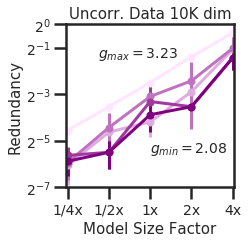

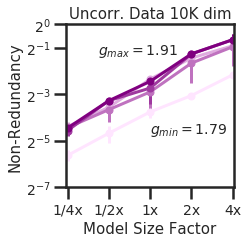

In [18]:

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curve_labels = ['1e-4', '1e-2', '1', '1e2', '1e4']
cm = seaborn.light_palette("purple", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o',  'o']
inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]
curves = 5

yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]
select_lr = [1e-1, 1e-2, 1e-3, 1e-3]
seeds = 3


#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))

units = [128]
# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        dataset_idx = dataset_idx_map["rand10000"]
        data_idx = data_idx_map[1e3]
        init_idx = init_idx_map[inits_fact[curve_idx]]
         
        for size_idx in range(sizes):
            id_best = int(IDs[0][seed, dataset_idx, data_idx, optimizer_idx, init_idx, size_idx])
            opt = experiments.opt[id_best]

            comp = set_results(id_best, experiments, size_idx, units)
            update_results(comp, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0, 1/4,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0.01, 0.01)

print_similarity('Uncorr. Data 10K dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 10, leg_loc, False,
                "red_synth_10k_initializer", True, False, slopes)

print_similarity('Uncorr. Data 10K dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 10, leg_loc, False,
                "nonred_synth_10k_initializer", True, True, slopes_no)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


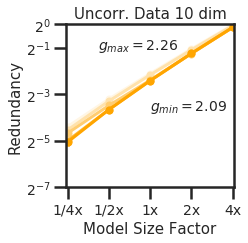

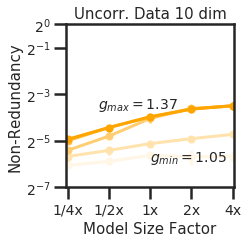

In [19]:
#Init - MLPs

sys.path.append('../')
import experiments

curves = 5
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]
yticks = [0, 16, 32, 48, 64]  ### SC
yticks_log = [1/64, 1/16, 1/4, 1, 4, 16, 64]  ### SC
curves = 5
curve_labels = ['1e-4', '1e-2', '1', '1e2', '1e4']
cm = seaborn.light_palette("orange", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o',  'o']

sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']

crosses=3
seeds = 3

#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))

units = [128]
# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        dataset_idx = dataset_idx_map["rand10"]
        data_idx = data_idx_map[1e3]
        init_idx = init_idx_map[inits_fact[curve_idx]]
         
        for size_idx in range(sizes):
            id_best = int(IDs[0][seed, dataset_idx, data_idx, optimizer_idx, init_idx, size_idx])
            opt = experiments.opt[id_best]

            comp = set_results(id_best, experiments, size_idx, units)
            update_results(comp, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0,  1/2**3, 1/4]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0.01, 0.01)
print_similarity('Uncorr. Data 10 dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 10, leg_loc, False,
                "red_synth_10_initializer", True, False, slopes)
leg_loc = (0.01, 0.4)
print_similarity('Uncorr. Data 10 dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 10, leg_loc, False,
                "nonred_synth_10_initializer", True, True, slopes_no)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


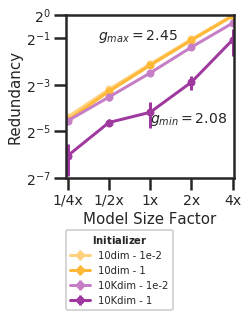

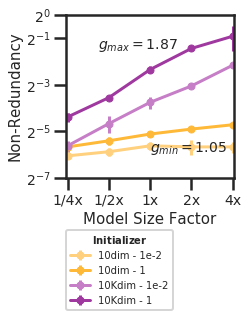

In [20]:
#Init - MLPs

sys.path.append('../')
import experiments

curves = 5
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]
yticks = [0, 16, 32, 48, 64]  ### SC
yticks_log = [1/64, 1/16, 1/4, 1, 4, 16, 64]  ### SC
curves = 4
curve_labels = ['10dim - 1e-2', '10dim - 1', '10Kdim - 1e-2', '10Kdim - 1']
cm_orange = seaborn.light_palette("orange", as_cmap=True)
cm_purple = seaborn.light_palette("purple", as_cmap=True)

curve_colors = [cm_orange(0.45), cm_orange(0.75),cm_purple(0.45), cm_purple(0.75)]
curve_styles = ['-', '-',  '-', '-']
marker_styles = ['o', 'o',  'o',  'o']

sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']

crosses=3
seeds = 3


#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))
results_no = np.zeros((seeds,crosses, len(alexnet_units), curves, sizes))

units = [128]
# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        if curve_idx < 2:
            dataset_idx = dataset_idx_map["rand10"]
        else:
            dataset_idx = dataset_idx_map["rand10000"]

        data_idx = data_idx_map[1e3]
        if curve_idx == 0 or curve_idx == 2:
            init_idx = init_idx_map[1e-2]
        else:
            init_idx = init_idx_map[1e0]

         
        for size_idx in range(sizes):
            id_best = int(IDs[0][seed, dataset_idx, data_idx, optimizer_idx, init_idx, size_idx])
            opt = experiments.opt[id_best]

            comp = set_results(id_best, experiments, size_idx, units)
            update_results(comp, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)



yticks_log = [1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0,  1/2**3, 1/4]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0, -0.81)

print_similarity('', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 10, leg_loc, True,
                "red_synth_summary", True, False, slopes)

print_similarity('', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 10, leg_loc, True,
                "nonred_synth_summary", True, True, slopes_no)

OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


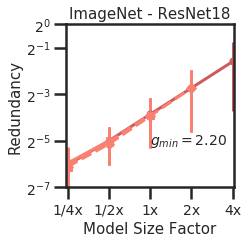

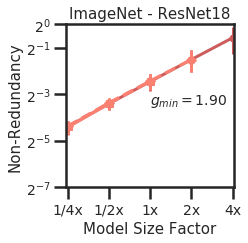

In [21]:
#ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
yticks = [0, 1, 2]  ### SC
yticks_log = [1/64, 1/16, 1/4, 1, 2]  ### SC
curves = 4
curve_labels = ['max.',  '4096', '2048', '1024']
curve_colors = ['indianred', 'salmon', 'salmon', 'salmon']
curve_styles = ['-', '-', '--', '--']
marker_styles = ['o', 'v', 's', 'D']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3
seed = 0
seeds = 1

resnet18_units = [64, 64, 128, 256, 512]  ### SC
inception_units = [32, 32, 64, 80, 192, 256, 288, 288, 786, 786, 786, 786, 786, 1280, 2048, 2048]
inception_layer_units = 288

results = np.zeros((seeds, len(resnet18_units), curves, sizes))
results_no = np.zeros((seeds, len(resnet18_units), curves, sizes))
# both are indexed [nn_type][size_factor]

for ID in range(5):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]
    
    comp = set_results_imagenet(ID, experiments, size_idx, resnet18_units)
    update_results_imagenet(comp, 4, curve_idx, size_idx, opt.dnn.factor)
                

batch_plot = [4096, 2048, 1024]
for ID in range(13):

    #print('Processing ID:', ID)
    opt = opts[ID]

    size_idx = size_idx_map[opt.dnn.factor]
    curve_idx = np.where(np.asarray(batch_plot) == opt.hyper.batch_size)[0] + 1
    
    comp = set_results_imagenet(ID, experiments, size_idx, resnet18_units)
    update_results_imagenet(comp, 4, curve_idx, size_idx, opt.dnn.factor)

    
results = get_mean_std_imagenet(results)
results_no = get_mean_std_imagenet(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)



yticks_log = [ 1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0,  1/4, 1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
leg_loc = (0.01, 0.37)

leg_loc = (0.01, 0.36)

print_similarity('ImageNet - ResNet18', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Batch} \bf{Size}$", 10, leg_loc, False,
                "red_imagenet_batch", True, False, slopes)

print_similarity('ImageNet - ResNet18', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Batch} \bf{Size}$", 10, leg_loc, False,
                "nonred_imagenet_batch", True, True, slopes_no)



OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

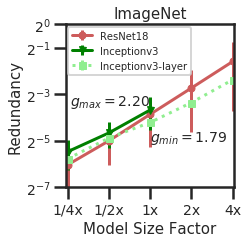

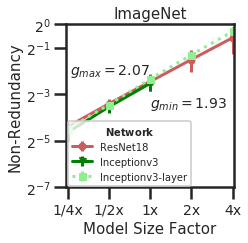

In [22]:
#ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
yticks = [0, 1, 2]  ### SC
yticks_log = [1/32, 1/8, 1/2, 2]  ### SC

curves = 3
curve_labels = ['ResNet18',  'Inceptionv3', 'Inceptionv3-layer']
curve_colors = ['indianred', 'green', 'lightgreen']
curve_styles = ['-', '-', ':']
marker_styles = ['o', 'v', 's']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 0

seeds = 1
seed = 0

resnet18_units = [64, 64, 128, 256, 512]  ### SC
inception_units = [32, 32, 64, 80, 192, 256, 288, 288, 786, 786, 786, 786, 786, 1280, 2048, 2048]
inception_layer_units = [288]


results_final = np.zeros((curves, sizes,2))
results_no_final = np.zeros((curves, sizes,2))

results = np.zeros((seeds, len(resnet18_units), curves, sizes))
results_no = np.zeros((seeds, len(resnet18_units), curves, sizes))
# both are indexed [nn_type][size_factor]

for ID in range(5):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]
    
    comp = set_results_imagenet(ID, experiments, size_idx, resnet18_units)
    update_results_imagenet(comp, 4, curve_idx, size_idx, opt.dnn.factor)

results_final[0,:,:] = get_mean_std_imagenet(results)[0,:,:]
results_no_final[0,:,:] = get_mean_std_imagenet(results_no)[0,:,:]


results = np.zeros((seeds, len(inception_units), curves, sizes))
results_no = np.zeros((seeds, len(inception_units), curves, sizes))
for ID in range(12,15):

    #print('Processing ID:', ID)
    opt = opts[ID]

    size_idx = size_idx_map[opt.dnn.factor]
    
    comp = set_results_imagenet(ID, experiments, size_idx, inception_units)
    update_results_imagenet(comp, 4, curve_idx, size_idx, opt.dnn.factor)

results_final[1,:,:] = get_mean_std_imagenet(results)[0,:,:]
results_no_final[1,:,:] = get_mean_std_imagenet(results_no)[0,:,:]
    
factor_map = {12: 1, 15: 0.25, 16: 0.5, 17: 2, 18: 4}
results = np.zeros((seeds, len(inception_layer_units), curves, sizes))
results_no = np.zeros((seeds, len(inception_layer_units), curves, sizes))
for ID in list(range(12,13)) + list(range(15,19)):

    #print('Processing ID:', ID)
    opt = opts[ID]

    size_idx = size_idx_map[opt.dnn.factor_end]
    
    comp = set_results_imagenet(ID, experiments, size_idx, inception_layer_units,'7')
    update_results_imagenet(comp, 4, curve_idx, size_idx, factor_map[ID])

results_final[2,:,:] = get_mean_std_imagenet(results)[0,:,:]
results_no_final[2,:,:] = get_mean_std_imagenet(results_no)[0,:,:]


slopes= get_slope(results_final)
slopes_no= get_slope(results_no_final)


yticks_log = [ 1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0,  1/4, 1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

leg_loc = (0.01, 0.69)

print_similarity('ImageNet', results_final, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, "", 10, leg_loc, True,
                "red_imagenet", True, False, slopes)

leg_loc = (0.01, 0.01)

print_similarity('ImageNet', results_no_final, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network}$", 10, leg_loc, True,
                "nonred_imagenet", True, True, slopes_no)


OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

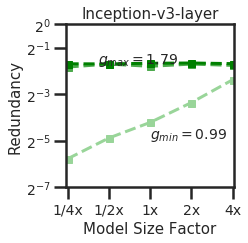

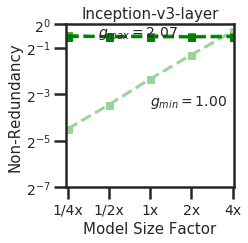

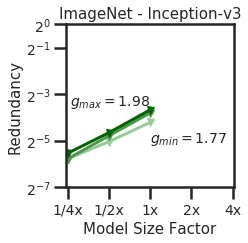

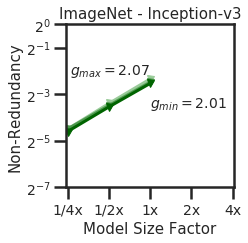

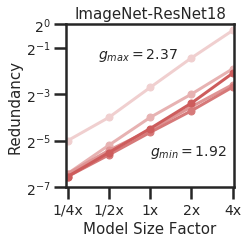

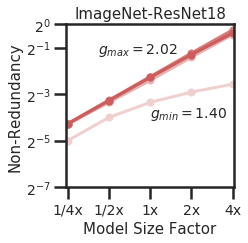

In [23]:
#Layers - ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
yticks = [0, 2, 4, 8, 16]#, 20, 40, 80]

curves = 3
curve_labels = ['final-35x35',  'final-17x17', 'final-8x8']
cm = seaborn.light_palette("green", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=4)][1:]
curve_styles = ['--', '--', '--']
marker_styles = ['s', 's', 's']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3

seeds = 1
seed = 0

resnet18_units = [64, 64, 128, 256, 512]  ### SC
inception_units = [32, 32, 64, 80, 192, 256, 288, 288, 786, 786, 786, 786, 786, 1280, 2048, 2048]
inception_layer_units = [288]

# both are indexed [nn_type][size_factor]
results = np.zeros((seeds, 1, curves, sizes))
results_no = np.zeros((seeds, 1, curves, sizes))
    
for ID in list(range(12,13)) + list(range(15,19)):
    for idx_layer, layer in enumerate([7, 13, 15]):
        #print('Processing ID:', ID)
        opt = opts[ID]

        size_idx = size_idx_map[opt.dnn.factor_end]
        comp = set_results_imagenet(ID, experiments, size_idx, inception_layer_units,str(layer))
        if layer == 7:
            update_results_imagenet(comp, 4, idx_layer, size_idx, factor_map[ID])
        else:
            results[seed, :, idx_layer, size_idx] = comp 
            results_no[seed, :, idx_layer, size_idx] = 1 - comp 


    
results = get_mean_std_imagenet(results)
results_no = get_mean_std_imagenet(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)



yticks_log = [ 1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
yticks_log2 = [0,  1/4, 1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC
leg_loc = (0.01, 0.01)

print_similarity('Inception-v3-layer', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 10, leg_loc, False,
                "red_imagenet_inception_layer", True, False, slopes)

print_similarity('Inception-v3-layer', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 10, leg_loc, False,
                "nonred_imagenet_inception_layer", True, True, slopes_no)


curves = 3
curve_labels = ['final-35x35',  'final-17x17', 'final-8x8']
cm = seaborn.light_palette("darkgreen", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=4)][1:]
curve_styles = ['-', '-', '-']
marker_styles = ['v', 'v', 'v']

# both are indexed [nn_type][inception_units]
results = np.zeros((seeds, 1, curves, sizes))
results_no = np.zeros((seeds, 1, curves, sizes))
for ID in range(12,15):
    for idx_layer, layer in enumerate([7, 13, 15]):
        #print('Processing ID:', ID)
        opt = opts[ID]

        size_idx = size_idx_map[opt.dnn.factor]
        comp = set_results_imagenet(ID, experiments, size_idx, inception_layer_units, str(layer))
        update_results_imagenet(comp, 4, idx_layer, size_idx, opt.dnn.factor)

        
results = get_mean_std_imagenet(results)
results_no = get_mean_std_imagenet(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

leg_loc = (0.01, 0.49)

print_similarity('ImageNet - Inception-v3', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 10, leg_loc, False,
                "red_imagenet_inception_all_layer", True, False, slopes)

print_similarity('ImageNet - Inception-v3', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 10, leg_loc, False,
                "nonred_imagenet_inception_all_layer", True, True, slopes_no)


 
curves = 5
curve_labels = ['init-conv',  'block-1', 'block-2','block-3','block-4']
cm = seaborn.light_palette("indianred", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=curves+1)][1:]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o', 'o']
yticks = [0,  4, 8, 16,32]#, 20, 40, 80]


results = np.zeros((seeds, 1, curves, sizes))
results_no = np.zeros((seeds, 1, curves, sizes))
for ID in range(5):
    for idx_layer, layer in enumerate([0, 1, 2, 3, 4]):
        #print('Processing ID:', ID)
        opt = opts[ID]

        size_idx = size_idx_map[opt.dnn.factor]
        comp = set_results_imagenet(ID, experiments, size_idx, inception_layer_units, str(layer))
        update_results_imagenet(comp, 4, idx_layer, size_idx, opt.dnn.factor)

        
results = get_mean_std_imagenet(results)
results_no = get_mean_std_imagenet(results_no)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

leg_loc = (0.01, 0.27)

print_similarity('ImageNet-ResNet18', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 10, leg_loc, False,
                "red_imagenet_resnet_all_layer", True, False, slopes)

print_similarity('ImageNet-ResNet18', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 10, leg_loc, False,
                "nonred_imagenet_resnet_all_layer", True, True, slopes_no)



OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

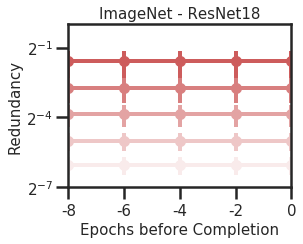

In [24]:
#Time - ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')

curves = 5
curve_labels = ['x1/4',  'x1/2', 'x1', 'x2', 'x4']
cm = seaborn.light_palette("indianred", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o', 'o']
sizes = 5
size_factors = np.array([-4, -3, -2, -1, 0])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['-8', '-6', '-4', '-2', '0']

results = np.zeros((curves, sizes,2))
units = [64, 64, 128, 256, 512]  ### SC

# both are indexed [nn_type][size_factor]

for ID in range(19, 39):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]

            
    csv_file = opt.csv_dir + opt.name + '_redundancy.csv'
    df = pd.read_csv(csv_file)
    
    comp = set_results_imagenet(ID, experiments, size_idx, units)
    results[size_idx][opt.time_step][0] = np.mean(comp)*(1/4) * opt.dnn.factor
    results[size_idx][opt.time_step][1] = np.std(comp* (1/4) * opt.dnn.factor)
    
for ID in range(5):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]
    
    csv_file = opt.csv_dir + opt.name + '_redundancy.csv'
    df = pd.read_csv(csv_file)
    comp = set_results_imagenet(ID, experiments, size_idx, units)
    results[size_idx][-1][0] = np.mean(comp)*(1/4) * opt.dnn.factor
    results[size_idx][-1][1] = np.std(comp*(1/4) * opt.dnn.factor)

    
data = results[:, :, 0]
stds = results[:, :, 1]/2

title = r'ImageNet - ResNet18'
leg_title = r"$\bf{Model} \bf{Size}$"
leg_flag = True
rand_base = 0.1

leg_loc = (0.7, 0.040)
yticks= [ 1/128, 1/2**5,1/8,1/2,1]#[1/(2**12) ,1/1024, 1/256, 1/64, 1/16, 1/4]  ### SC

fig, ax = plt.subplots(figsize=(4, 3))
plt.title(title , fontsize=25)
plt.xlabel(r'Epochs before Completion', fontsize=25)
plt.ylabel('Redundancy', fontsize=25)
plt.xlim((-4, 0))
plt.ylim((-1, 5))
#plt.grid(True, which='both')
plt.xticks(size_factors, size_labels)

plt.yticks(yticks)
ax.xaxis.tick_bottom() ### CHANGED
ax.yaxis.tick_left() ### CHANGED
plt.yscale('log', basey=2)
plt.ylim((np.min(yticks), np.max(yticks)))

for curve_idx in range(np.shape(data)[0]):
    non_0_idx = (data[curve_idx] != 0)
    plt.errorbar(size_factors[non_0_idx], data[curve_idx][non_0_idx], yerr=stds[curve_idx][non_0_idx], marker=marker_styles[curve_idx], color=curve_colors[curve_idx],
             linestyle=curve_styles[curve_idx], linewidth=4, markersize=10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

if False:
    leg = plt.legend(curve_labels, loc=leg_loc, framealpha=0.8, fontsize=12, title=leg_title)
    leg.get_title().set_fontsize('12')
plt.rc('xtick',labelsize=8)

plt.show()
fig.savefig("red_imagenet_dynamics.pdf",format='pdf', bbox_inches='tight',dpi=1000)
    